In [1]:
from functional_alignment.probabilistic_srm import ProbabilisticSRM
from mpi4py import MPI
from brainiak_srm import SRM
import matplotlib.pyplot as plt
from generator import create_orthogonal_matrix, generate_group_sparse_matrix, generate_random_orthogonal_matrix
from generator import generate_close_group_sparse_matrices
from generator import generate_fake_data
import numpy as np
from nilearn.input_data import NiftiMasker
import nibabel

In [2]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = None

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout

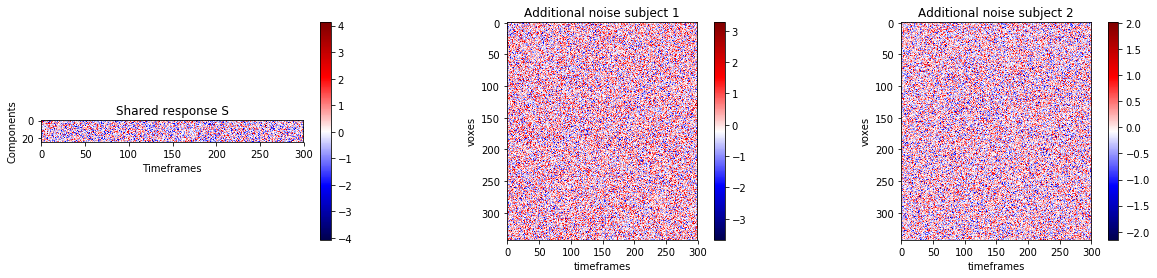

-------------------------------------------------------------------------------------
orthogonal


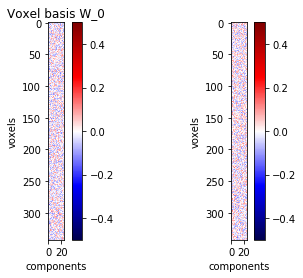

random


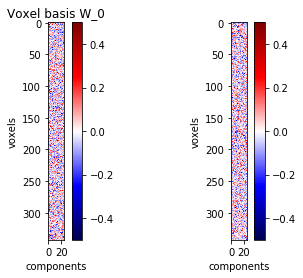

sparse


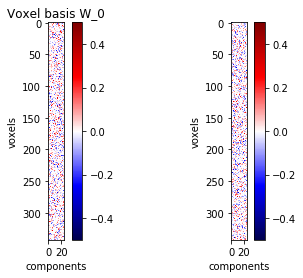

group_sparse


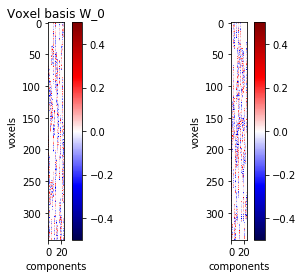

close_group_sparse


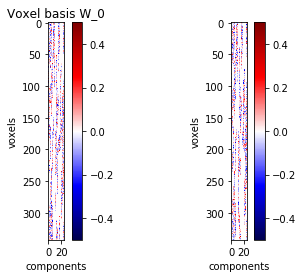

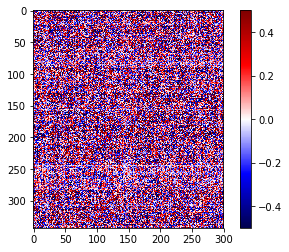

In [3]:
#n_samples is the number of subject
#n_component is the dimension of latent space


n_subjects = 20
n_components = 25
voxels = (7, 7, 7)
n_timeframes = 300

affine = np.eye(4)
shape = (voxels[0], voxels[1], voxels[2], n_timeframes)

masker = NiftiMasker(mask_img=nibabel.Nifti1Image(np.ones(shape[:3], dtype=np.int8), affine)).fit()

#parameters
noise_scale = np.random.normal(loc=0, scale=0.7, size=n_subjects)**2
isotropicLatentVariance = np.eye(n_components)
isotropicLatentVariance = isotropicLatentVariance.T.dot(isotropicLatentVariance)

data = generate_fake_data(n_subjects=n_subjects,
                          n_components=n_components,
                          n_voxels=np.array(voxels).prod(),
                          n_timeframes=n_timeframes,
                          noise_scale=noise_scale,
                          latent_variance=isotropicLatentVariance,
                         )

train_W = data["train_W"]
train_S = data["train_S"]
test_S = data["test_S"]
test_noise = data["test_noise"]
train_noise = data["train_noise"]

methods = ["orthogonal", "random", "sparse", "group_sparse", "close_group_sparse"]
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.title("Shared response S")
plt.imshow(data["train_S"], cmap="seismic")
plt.xlabel("Timeframes")
plt.ylabel("Components")
plt.colorbar()
plt.subplot(132)
plt.title("Additional noise subject 1")
plt.imshow(data["train_noise"][0], cmap="seismic")
plt.xlabel("timeframes")
plt.ylabel("voxes")
plt.colorbar()
plt.subplot(133)
plt.title("Additional noise subject 2")
plt.imshow(data["train_noise"][1], cmap="seismic")
plt.xlabel("timeframes")
plt.ylabel("voxes")
plt.colorbar()
plt.savefig('fig1')
plt.show()

# print("Shared response (S of size k, t)")
# plt.imshow(test_S)
# plt.colorbar()
# plt.show()
print("-------------------------------------------------------------------------------------")
for method in methods:
    print(method)
    plt.subplot(121)
    i = 0
    plt.title("Voxel basis W_%i"%(i))
    plt.imshow(data["train_W"][method][i], cmap="seismic", vmax=0.5, vmin=-0.5)
    plt.ylabel("voxels")
    plt.xlabel("components")
    plt.colorbar()
    plt.subplot(122)
    i=1
    plt.imshow(data["train_W"][method][i], cmap="seismic", vmax=0.5, vmin=-0.5)
    plt.ylabel("voxels")
    plt.xlabel("components")
    plt.colorbar()
    plt.savefig('fig2_%s'%method)
    plt.show()

plt.imshow(data["train_W"][method][i].dot(train_S), cmap="seismic", vmax=0.5, vmin=-0.5)
plt.colorbar()

orthogonal


/usr/local/lib/python3.6/site-packages/nilearn/input_data/masker_validation.py:74: UserWarning: Overriding provided-default estimator parameters with provided masker parameters :
Parameter mask_strategy :
    Masker parameter background - overriding estimator parameter epi

  warnings.warn(warn_str)


random
sparse
group_sparse
close_group_sparse


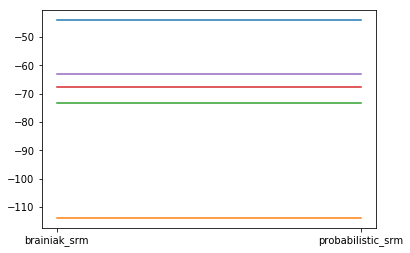

In [13]:
import sys

for i in range(len(methods)):
    method = methods[i]
    print(method)
    with HiddenPrints():
        brainiak_srm = SRM(features=n_components)
        probabilistic_srm = ProbabilisticSRM(n_components=n_components, mask=masker)
        train = [train_W[method][k].dot(train_S) + train_noise[k]
                for k in range(n_subjects)
        ]
        masked_train = [[
                masker.inverse_transform(
                    (train_W[method][k].dot(train_S) + train_noise[k]).T
                )]
                for k in range(n_subjects)
        ]

        test = [[train_W[method][k].dot(test_S) + test_noise[k]]
                for k in range(n_subjects)
        ]
        masked_test = [[
            masker.inverse_transform(
                (train_W[method][k].dot(test_S) + test_noise[k]).T
            )]
            for k in range(n_subjects)
        ]
        
        brainiak_srm.fit(train)
        probabilistic_srm.fit(masked_train)
        
        errors = []
        error = []
        for s in range(n_subjects):
            index = np.delete(range(0, n_subjects), s)
            predicted_S = brainiak_srm.transform([test[ii][0] for ii in index], index=index)
            err = np.linalg.norm(test[s][0] - brainiak_srm.inverse_transform(predicted_S)[s])
            best_err = np.linalg.norm(test[s][0] - train_W[method][s].dot(test_S)[s])
            error.append(err - best_err)
        errors.append(np.mean(error))
        error = []
        for s in range(n_subjects):
            index = np.delete(range(0, n_subjects), s)
            predicted_S = probabilistic_srm.transform([masked_test[ii] for ii in index], index=index)
            err = np.linalg.norm(test[s][0] - probabilistic_srm.inverse_transform(predicted_S)[s])
            best_err = np.linalg.norm(test[s][0] - train_W[method][s].dot(test_S)[s])
            error.append(err - best_err)
        errors.append(np.mean(error))
        
        plt.plot(["brainiak_srm", "probabilistic_srm"], errors)
            
    